## Implementing a bubble sheet scanner and grader using OMR, Python, and OpenCV

In [1]:
from imutils.perspective import four_point_transform #to perform a 4-point perspective transform of a ROI in an image and obtain a top-down, "birds eye view" of the ROI. 
from imutils import contours
import numpy as np
import argparse
import imutils
import cv2
ANSWER_KEY = {0: 1, 1: 4, 2: 0, 3: 3, 4: 1}

imutils tutorials : https://github.com/jrosebr1/imutils

In [2]:
# load the image, convert it to grayscale, blur it
# slightly, then find edges
image = cv2.imread('1.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(blurred, 75, 200)

In [3]:
cv2.imwrite('kl.png',edged)

True

In [4]:
# find contours in the edge map, then initialize
# the contour that corresponds to the document
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)#contour refers to outline of boundary of an object
#so now cnts contains coordinates of boundary of every object it detected in image  
cnts = cnts[0] if imutils.is_cv2() else cnts[1] #depends on version of opencv
docCnt = None
# ensure that at least one contour was found
if len(cnts) > 0:
# sort the contours according to their size in descending order
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
# loop over the sorted contours
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
#if our approximated contour has four points then we can assume we have found the paper
        if len(approx) == 4:
            docCnt = approx
            break

 

Edges are computed as points that are extrema of the image gradient in the direction of the gradient. if it helps, you can think of them as the min and max points in a 1D function. The point is, edge pixels are a local notion: they just point out a significant difference between neighbouring pixels.

Contours are often obtained from edges, but they are aimed at being object contours. Thus, they need to be closed curves. You can think of them as boundaries (some Image Processing algorithms & librarires call them like that). When they are obtained from edges, you need to connect the edges in order to obtain a closed contour.


In [5]:
docCnt

array([[[131, 206]],

       [[119, 617]],

       [[448, 614]],

       [[430, 208]]], dtype=int32)

In [6]:
pic=cv2.drawContours(image,docCnt,-1,(0,255,0),50)

In [7]:
cv2.imwrite('pic.png',pic)

True

In [8]:
import matplotlib.pyplot as plt

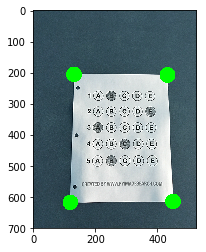

In [9]:
plt.imshow(pic)

In [10]:
# apply a four point perspective transform to both the
# original image and grayscale image to obtain a top-down
# birds eye view of the paper
paper = four_point_transform(image, docCnt.reshape(4, 2))
warped = four_point_transform(gray, docCnt.reshape(4, 2))

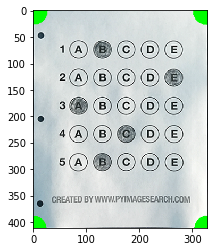

In [11]:
plt.imshow(paper)

Alright, so now we’re getting somewhere.

We found our exam in the original image.

We applied a perspective transform to obtain a 90 degree viewing angle of the document.

But how do we go about actually grading the document?

This step starts with binarization, or the process of thresholding/segmenting the foreground from the background of the image:

In [12]:
# apply Otsu's thresholding method to binarize the warped
# piece of paper
thresh = cv2.threshold(warped, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]#Image binarization converts an image of up to 256 gray levels to a black and white image. Frequently, binarization is used as a pre-processor before OCR.

Image Binarization 	

    Image binarization converts an image of up to 256 gray levels to a black and white image. Frequently, binarization is used as a pre-processor before OCR. In fact, most OCR packages on the market work only on bi-level (black & white) images.
    The simplest way to use image binarization is to choose a threshold value, and classify all pixels with values above this threshold as white, and all other pixels as black. The problem then is how to select the correct threshold. In many cases, finding one threshold compatible to the entire image is very difficult, and in many cases even impossible. Therefore, adaptive image binarization is needed where an optimal threshold is chosen for each image area. 

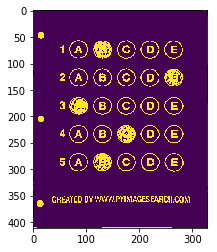

In [13]:
plt.imshow(thresh)

Notice how the background of the image is black, while the foreground is white.

This binarization will allow us to once again apply contour extraction techniques to find each of the bubbles in the exam:

In [14]:
# find contours in the thresholded image, then initialize the list of contours that correspond to questions
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if imutils.is_cv2() else cnts[1]
questionCnts = []
 
# loop over the contours
for c in cnts:
    # compute the bounding box of the contour, then use the
    # bounding box to derive the aspect ratio
    (x, y, w, h) = cv2.boundingRect(c)
    ar = w / float(h)

    # in order to label the contour as a question, region
    # should be sufficiently wide, sufficiently tall, and
    # have an aspect ratio approximately equal to 1
    if w >= 20 and h >= 20 and ar >= 0.9 and ar <= 1.1:
            #cv2.rectangle(thresh,(x,y),(x+w,y+h),(0,255,0),60)
            questionCnts.append(c)

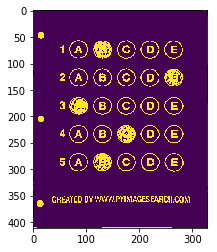

In [15]:
plt.imshow(thresh)

for (i, c) in enumerate(questionCnts):
    print (i)
    cv2.drawContours(thresh, c, i,(0,255,0),3)

To determine which regions of the image are bubbles, we first loop over each of the individual contours .

For each of these contours, we compute the bounding box , which also allows us to compute the aspect ratio, or more simply, the ratio of the width to the height.

In order for a contour area to be considered a bubble, the region should:

    Be sufficiently wide and tall (in this case, at least 20 pixels in both dimensions).
    Have an aspect ratio that is approximately equal to 1.

As long as these checks hold, we can update our questionCnts  list and mark the region as a bubble.

In [16]:
questionCnts = contours.sort_contours(questionCnts,
	method="top-to-bottom")[0]#in this way first row will be on 0-4 in questionCnts and 2nd row in 5-10 and so on then after that we can apply left to right sorting to sort each question circle contour
#https://www.pyimagesearch.com/2015/04/20/sorting-contours-using-python-and-opencv/(for help)

In [17]:
len(questionCnts)

25

In [18]:
correct = 0
cnts=[]
# each question has 5 possible answers, to loop over the
# question in batches of 5
for (q, i) in enumerate(np.arange(0, len(questionCnts), 5)):

	# sort the contours for the current question from
	# left to right, then initialize the index of the
	# bubbled answer
	cnts.append(contours.sort_contours(questionCnts[i:i + 5])[0])#now our contours will be sorted like first five entries belongs to q1 and are arranged left to right like 0 belong to A 1 belong to B and so on
	print(len(cnts))    


1
2
3
4
5


Given a row of bubbles, the next step is to determine which bubble is filled in.

We can accomplish this by using our thresh  image and counting the number of non-zero pixels (i.e., foreground pixels) in each bubble region:

In OpenCV, a mask image is of type uint8_t. Pixels of value 0xFF are true and pixels of value 0 are false.

A mask can be applied on an image of the same dimensions, but of any type. By applying a mask M on an image I, the pixels of I whose corresponding pixel in M are true are copied into a new image. The rest of the pixels in the new image are set to 0.

In [21]:
mask = np.zeros(thresh.shape, dtype="uint8")
cv2.drawContours(mask, [cnts[0][0]], -1, 255, -1)



array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

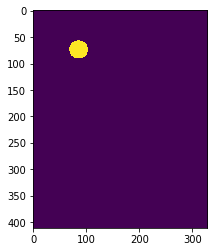

In [22]:
plt.imshow(mask)

In [23]:
# apply the mask to the thresholded image, then count the number of non-zero pixels in the bubble area
mask = cv2.bitwise_and(thresh, thresh, mask=mask)

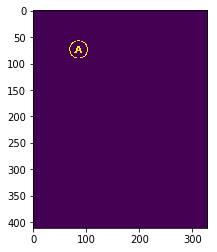

In [24]:
plt.imshow(mask)

In [25]:
total = cv2.countNonZero(mask)
print(total) 
# if the current total has a larger number of total non-zero pixels, then we are examining the currently bubbled-in answer

289


Repeating same process of masking for bubbled answer B

817


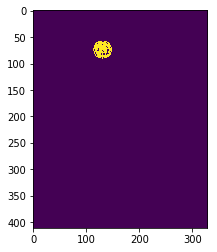

In [26]:
mask = np.zeros(thresh.shape, dtype="uint8")
cv2.drawContours(mask, [cnts[0][1]], -1, 255, -1)
plt.imshow(mask)
# apply the mask to the thresholded image, then count the number of non-zero pixels in the bubble area
mask = cv2.bitwise_and(thresh, thresh, mask=mask)
plt.imshow(mask)
total = cv2.countNonZero(mask)
print(total) 
# if the current total has a larger number of total non-zero pixels, then we are examining the currently bubbled-in answer

So we going to apply this in loop for all bubbles we found using contours

In [27]:
bubbled=[]
for (j, c) in enumerate(cnts):
            i=0
            for k in c:
               
                # construct a mask that reveals only the current "bubble" for the question
                mask = np.zeros(thresh.shape, dtype="uint8")
                cv2.drawContours(mask, [k], -1, 255, -1)
                mask=cv2.bitwise_and(thresh,thresh,mask=mask)
                total = cv2.countNonZero(mask)
                
                if (total>400):
                    bubbled.append(i)
                i=i+1   
print(bubbled)        

[1, 4, 0, 2, 1]


In [28]:
correct=0
for i in range(len(ANSWER_KEY)):
    if(bubbled[i]==ANSWER_KEY[i]):
        correct=correct+1
        print('correct')
    else:
        print('incorrect')
score = (correct / 5.0) * 100 
print('score is %d percentage'% score)

correct
correct
correct
incorrect
correct
score is 80 percentage
